<a href="https://colab.research.google.com/github/tariqshaban/svd-transformation/blob/master/SVD%20Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [ ]:
# Download spaCy's Deutsch trained pipelines
!python -m spacy download nl_core_news_sm

# Install sentence-transformers, for implementing SentenceBERT
!pip install sentence-transformers

# Install Facebook's InferSent supervised sentence embedding technique
import os
!mkdir -p assets/infer_sent/encoder
!curl -Lo assets/infer_sent/encoder/model.py https://raw.githubusercontent.com/facebookresearch/InferSent/main/models.py
!curl -Lo assets/infer_sent/encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
!mkdir -p assets/infer_sent/glove
!pip install kaggle
!gdown --id 1tFeb9OTQH0T_CUmWin8DkcrYwZP0ao8y
!chmod 600 kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d gerwynng/glove-common-crawl-840b-tokens
!mv glove-common-crawl-840b-tokens.zip /content/assets/infer_sent/glove
!unzip assets/infer_sent/glove/glove-common-crawl-840b-tokens.zip -d assets/infer_sent/glove/

# Required for multilingual universal sentence encoder
!pip install tensorflow_text

# Enabling colored terminal text for warnings
!pip install colorama

import json
import re
import string
import nltk
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow_text
import nl_core_news_sm
import en_core_web_sm
import torch

from colorama import Fore, Back, Style
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from enum import Enum
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy import spatial
from scipy import stats
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import clear_output
from assets.infer_sent.encoder.model import InferSent
import matplotlib.pyplot as plt

# Download NLTK's stopwords
nltk.download('stopwords')
# Download NLTK's tokenizer
nltk.download('punkt')

# Download compressed assets from Google Drive
!gdown 1TTddIx7Bwwl2o3hYnMKDXxJEskiPMXde
!unrar x "assets.rar"

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Enumerations

##### Enumerating vectorization techniques

In [ ]:
class Vectorizer(Enum):
    """
    Enumerating vectorization techniques.

    Values
    -------
    **TF_IDF_VECTORIZER:** Convert a collection of raw documents to a matrix of TF-IDF features, see
    `documentation <TF_IDF_VECTORIZER_>`_.

    **COUNT_VECTORIZER:** Convert a collection of text documents to a matrix of token counts, see
    `documentation <COUNT_VECTORIZER_>`_.

    **HASHING_VECTORIZER:** Convert a collection of text documents to a matrix of token occurrences, see
    `documentation <HASHING_VECTORIZER_>`_.

    **DOC2VEC:** Learn document embeddings via the distributed memory and distributed bag of words models, see
    `documentation <DOC2VEC_>`_.

    **BERT:** Map sentences/text to embeddings using the `bert-base-nli-mean-tokens` pretrained model, see
    `documentation <BERT_>`_.

    **INFER_SENT:** An implementation that has a semantic representations for sentences, see
    `repository <INFER_SENT_>`_.

    **UNIVERSAL_SENTENCE_ENCODER:** Encoder of greater-than-word length text trained on a variety of data, see
    `documentation <UNIVERSAL_SENTENCE_ENCODER_1_>`_ and `notebook <UNIVERSAL_SENTENCE_ENCODER_2_>`_.

    .. _TF_IDF_VECTORIZER: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    .. _COUNT_VECTORIZER: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    .. _HASHING_VECTORIZER: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html
    .. _DOC2VEC: https://radimrehurek.com/gensim/models/doc2vec.html
    .. _BERT: https://www.sbert.net
    .. _INFER_SENT: https://github.com/facebookresearch/InferSent
    .. _UNIVERSAL_SENTENCE_ENCODER_1: https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
    .. _UNIVERSAL_SENTENCE_ENCODER_2: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cross_lingual_similarity_with_tf_hub_multilingual_universal_encoder.ipynb
    """
    TF_IDF_VECTORIZER = 'TfidfVectorizer_LEGACY'
    COUNT_VECTORIZER = 'CountVectorizer_LEGACY'
    HASHING_VECTORIZER = 'HashingVectorizer_LEGACY_INTENSIVE'
    DOC2VEC = 'doc2vec'
    BERT = 'bert_INTENSIVE'
    INFER_SENT = 'InferSent_INTENSIVE'
    UNIVERSAL_SENTENCE_ENCODER = 'universal-sentence-encoder'

##### Enumerating similarity metrics

In [ ]:
class Similarity(Enum):
    """
    Enumerating similarity metrics.

    Values
    -------
    **COSINE_SIMILARITY_PAIRWISE:** Compute cosine similarity between samples in X and Y, see
    `documentation <COSINE_SIMILARITY_PAIRWISE_>`_.

    **COSINE_SIMILARITY:** Compute the Cosine distance between 1-D arrays, see
    `documentation <COSINE_SIMILARITY_>`_.

    .. _COSINE_SIMILARITY_PAIRWISE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
    .. _COSINE_SIMILARITY: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
    """
    COSINE_SIMILARITY_PAIRWISE = 'cosine_similarity'
    COSINE_SIMILARITY = 'cosine'

##### Enumerating distance metrics

In [ ]:
class Distance(Enum):
    """
    Enumerating distance metrics.

    Values
    -------
    **EUCLIDEAN_DISTANCE:** Return one of eight different matrix norms; since the euclidean distance is the l2 norm, see
    `documentation <EUCLIDEAN_DISTANCE_>`_.

    **MANHATTAN_DISTANCE:** Compute the Manhattan distance between two 1-D arrays, see
    `example <MANHATTAN_DISTANCE_>`_.

    **MINKOWSKI_DISTANCE:** Compute the Minkowski distance between two 1-D arrays, see
    `documentation <MINKOWSKI_DISTANCE_>`_.

    .. _EUCLIDEAN_DISTANCE: https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    .. _MANHATTAN_DISTANCE: https://stackoverflow.com/a/62634895
    .. _MINKOWSKI_DISTANCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.minkowski.html
    """
    EUCLIDEAN_DISTANCE = 'norm'
    MANHATTAN_DISTANCE = 'minkowski'
    MINKOWSKI_DISTANCE = 'abs_sum'

##### Enumerating correlation/accuracy metrics

In [ ]:
class Correlation(Enum):
    """
    Enumerating correlation/accuracy metrics.

    Values
    -------
    **PEARSON_CORRELATION:** Pearson correlation coefficient and p-value for testing non-correlation, see
    `documentation <PEARSON_CORRELATION_>`_.

    **SPEARMAN_CORRELATION:** Calculate a Spearman correlation coefficient with associated p-value, see
    `documentation <SPEARMAN_CORRELATION_>`_.

    **POINT_BISERIAL_CORRELATION:** Calculate a point biserial correlation coefficient and its p-value, see
    `documentation <POINT_BISERIAL_CORRELATION_>`_.

    **KENDALL_TAU_CORRELATION:** Compute Calculate Kendall’s tau, a correlation measure for ordinal data, see
    `documentation <KENDALL_TAU_CORRELATION_>`_.

    .. _PEARSON_CORRELATION: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    .. _SPEARMAN_CORRELATION: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    .. _POINT_BISERIAL_CORRELATION: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
    .. _KENDALL_TAU_CORRELATION: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html
    """
    PEARSON_CORRELATION = 'pearsonr'    
    SPEARMAN_CORRELATION = 'spearmanr'
    POINT_BISERIAL_CORRELATION = 'pointbiserialr'
    KENDALL_TAU_CORRELATION = 'kendalltau'

# Helper Methods

#### Mounting tables into a dictionary of dataframes

In [ ]:
def get_raw_train_test() -> dict:
    """
    Loads training and testing CSV pairs into their respective dictionary key as a dataframe.

    :return: A dictionary denoting either a training dataframe or a testing dataframe as its values
    :rtype: dict
    """
    training = pd.read_csv('assets/training_pairs.csv')
    testing = pd.read_csv('assets/testing_pairs.csv')
    

    # Redefining train-test split since training data should have the highest count number of 'Overall'
    training_overhead = training[training['Overall']<2]
    testing_overhead = testing[testing['Overall']==4]
    row_relocating_thresh = min(len(training_overhead),len(testing_overhead))

    training_overhead = training_overhead.head(row_relocating_thresh)
    testing_overhead = testing_overhead.head(row_relocating_thresh)

    training = pd.merge(training,training_overhead, indicator=True, how='outer')\
        .query('_merge=="left_only"')\
        .drop('_merge', axis=1)

    testing = pd.merge(testing,testing_overhead, indicator=True, how='outer')\
        .query('_merge=="left_only"')\
        .drop('_merge', axis=1)

    training = pd.concat([training, testing_overhead], ignore_index=True)
    testing = pd.concat([testing, training_overhead], ignore_index=True)

    return {'train': training, 'test': testing}

#### Fetching textual data from the residual json assets

In [ ]:
def __get_json_text_by_id(file_id: str) -> str:
    """
    Fetches the value of the 'text' key in a JSON file for a specified id.

    :param str file_id: Denotes the file id, in which specifies which existing JSON file to fetch
    :return: The 'text' value from the JSON
    :rtype: str
    """
    try:
        file = open(f'assets/webpages/{file_id}.json')
        data = json.load(file)
        return data['text']
    except FileNotFoundError:
        return ''

#### Preprocessing dataframe

In [ ]:
def preprocess_df(df: pd.DataFrame):
    """
    Adds the text columns and discards unnecessary columns from the dataframe, 
    drops rows that have null values in text column.

    :param pd.DataFrame df: Specify which dataframe to apply the procedures on
    """
    # Retrieves textual data by pair_id
    df['Text1'] = df['pair_id'].apply(lambda cell: __get_json_text_by_id(cell.split('_')[0]))
    df['Text2'] = df['pair_id'].apply(lambda cell: __get_json_text_by_id(cell.split('_')[1]))

    # Remove unnecessary columns
    df.drop(df.columns.difference(['Text1', 'Text2', 'Overall']), axis=1, inplace=True)

    # Remove null & empty texts
    df['Text1'].replace('', None, inplace=True)
    df['Text2'].replace('', None, inplace=True)
    df.dropna(subset=['Text1', 'Text2'], inplace=True)

#### Implementing basic natural language processing procedures
* Removing punctuation
* Removing numbers
* Removing stops words for both Deutsch and English
* Removing escape sequences
* Lowercasing all characters
* Lemmatizing words

In [ ]:
def implement_nlp(df: pd.DataFrame, efficient: bool=True):
    """
    Implements basic natural language processing procedures on the text columns.

    :param pd.DataFrame df: Specify which dataframe to apply the procedures on
    :param bool efficient: Specify whether to lemmatize the words or not (CPU intensive)
    """
    remove_punctuation(df)
    remove_numbers(df)
    remove_stop_words(df)
    remove_escape_sequences(df)
    lowercase_characters(df)
    if not efficient:
      lemmatize_words(df)

In [ ]:
def remove_punctuation(df: pd.DataFrame, columns=None):
    """
    Removes the punctuations on selected columns.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    :param list columns: Specify which columns from the dataframe to apply the procedure on
    """
    if columns is None:
        columns = ['Text1', 'Text2']

    punctuation = list(string.punctuation)
    for column in columns:
        df[column] = df[column].apply(lambda row: ''.join([i for i in row if i not in punctuation]))

In [ ]:
def remove_numbers(df: pd.DataFrame, columns=None):
    """
    Removes the numbers on selected columns.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    :param list columns: Specify which columns from the dataframe to apply the procedure on
    """
    if columns is None:
        columns = ['Text1', 'Text2']

    for column in columns:
        df[column] = df[column].apply(lambda row: re.sub(r'\d+', '', row))

In [ ]:
def remove_stop_words(df: pd.DataFrame):
    """
    Removes the stop words on predefined columns, since it is a language-sensitive method.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    """
    stop_words_de = stopwords.words('dutch')
    stop_words_en = stopwords.words('english')
    df['Text1'] = df['Text1'].apply(lambda row: ' '.join([i for i in row.split() if i not in stop_words_de]))
    df['Text2'] = df['Text2'].apply(lambda row: ' '.join([i for i in row.split() if i not in stop_words_en]))


In [ ]:
def remove_escape_sequences(df: pd.DataFrame, columns=None):
    """
    Removes the escape sequences on selected columns (\t, \n, etc.).

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    :param list columns: Specify which columns from the dataframe to apply the procedure on
    """
    if columns is None:
        columns = ['Text1', 'Text2']

    escapes = ''.join([chr(char) for char in range(1, 32)])
    for column in columns:
        df[column] = df[column].apply(lambda row: ''.join([i for i in row if i not in escapes]))

In [ ]:
def lowercase_characters(df: pd.DataFrame, columns=None):
    """
    Lowercase all alphabetical texts on selected columns.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    :param list columns: Specify which columns from the dataframe to apply the procedure on
    """
    if columns is None:
        columns = ['Text1', 'Text2']

    for column in columns:
        df[column] = df[column].str.lower()

In [ ]:
def lemmatize_words(df: pd.DataFrame):
    """
    Returns each word to its base or dictionary form on predefined columns, since it is a language-sensitive method.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    """
    lemma_de = nl_core_news_sm.load()
    lemma_en = en_core_web_sm.load()
    df['Text1'] = df['Text1'].apply(lambda row: ' '.join([x.lemma_ for x in lemma_de(row)]))
    df['Text2'] = df['Text2'].apply(lambda row: ' '.join([x.lemma_ for x in lemma_en(row)]))

#### Converting textual data into an array of vectors based on a predefined vectorization technique

In [ ]:
def vectorize_text(df: pd.DataFrame, columns=None, method: Vectorizer = Vectorizer.TF_IDF_VECTORIZER):
    """
    Converts textual data into an array of vectors based on a predefined vectorization technique.

    :param pd.DataFrame df: Specify which dataframe to apply the procedure on
    :param list columns: Specify which columns from the dataframe to apply the procedure on
    :param Vectorizer method: Specify the vectorization method to use
    """
    if columns is None:
        columns = ['Text1', 'Text2']

    texts = []
    for column in columns:
        texts.extend(df[column])

    if method == Vectorizer.TF_IDF_VECTORIZER:
        vectorizer = TfidfVectorizer(max_features=4000)
    elif method == Vectorizer.COUNT_VECTORIZER:
        vectorizer = CountVectorizer(max_features=4000)
    elif method == Vectorizer.HASHING_VECTORIZER:
        vectorizer = HashingVectorizer(n_features=4000)
    elif method == Vectorizer.DOC2VEC:
        tokenized_sent = []
        for s in texts:
            tokenized_sent.append(word_tokenize(s.lower()))
        tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
        model = Doc2Vec(tagged_data, vector_size=2000)
        texts_vectorized = model.docvecs.vectors_docs.tolist()
    elif method == Vectorizer.BERT:
        model = SentenceTransformer('bert-base-nli-mean-tokens')
        texts_vectorized = model.encode(texts, show_progress_bar=True).tolist()
    elif method == Vectorizer.INFER_SENT:
        params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                        'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
        model = InferSent(params_model)
        model.load_state_dict(torch.load('assets/infer_sent/encoder/infersent2.pkl'))
        model.set_w2v_path('assets/infer_sent/glove/glove.840B.300d.txt')
        model.build_vocab(texts, tokenize=True)
        texts_vectorized = model.encode(texts).tolist()
    else:
        model = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')
        texts_vectorized = []
        for column in columns:
          texts_vectorized.extend(model(df[column]).numpy().tolist())
        
    if 'LEGACY' in method.value:
        x = vectorizer.fit_transform(texts)
        texts_vectorized = x.toarray().tolist()

    count = 1
    for column in columns:
        df[f'Vector{count}'] = texts_vectorized[:len(df[column])]
        texts_vectorized = texts_vectorized[len(df[column]):]
        count = count + 1

#### Calculating similarity between two vectors

In [ ]:
def calculate_similarity(x: list, y: list, method: Similarity = Similarity.COSINE_SIMILARITY_PAIRWISE) -> list:
    """
    Calculates similarity between two matrices.

    :param list x: The first matrix
    :param list y: The second matrix, that must be equal to 'x' in length
    :param Similarity method: Specify the similarity method to use
    :return: A list of the similarity score between each vector pair
    :rtype: list
    """
    if method == Similarity.COSINE_SIMILARITY_PAIRWISE:
        if not isinstance(x, list):
            x = x.tolist()
        if not isinstance(y, list):
            y = y.tolist()
        similarity = cosine_similarity(x, y).diagonal()
    else:
        similarity = np.array([])
        for x_vector, y_vector in zip(x, y):
            similarity = np.append(similarity, 1 - spatial.distance.cosine(x_vector, y_vector))

    return similarity

#### Calculating distance between two vectors

In [ ]:
def calculate_distance(x: list, y: list, method: Distance = Distance.EUCLIDEAN_DISTANCE) -> float:
    """
    Calculates distance between two matrices.

    :param list x: The first matrix
    :param list y: The second matrix, that must be equal to 'x' in length
    :param Distance method: Specify the distance method to use
    :return: The mean distance between each vector pair
    :rtype: float
    """
    if method == Distance.EUCLIDEAN_DISTANCE:
        distances = np.array([])
        for x_vector, y_vector in zip(x, y):
            distances = np.append(distances, np.linalg.norm(np.subtract(x_vector, y_vector)))
        distance = distances.mean()
    elif method == Distance.MINKOWSKI_DISTANCE:
        distances = np.array([])
        for x_vector, y_vector in zip(x, y):
            distances = np.append(distances, spatial.distance.minkowski(x_vector, y_vector, 3))
        distance = distances.mean()
    else:
        distances = np.array([])
        for x_vector, y_vector in zip(x, y):
            distances = np.append(distances, np.abs(np.subtract(x_vector, y_vector)).sum())
        distance = distances.mean()

    return distance

#### Calculating correlation between two vectors

In [ ]:
def calculate_correlation(x: list, y: list, z: list, method: Correlation = Correlation.PEARSON_CORRELATION,
                          similarity_method: Similarity = Similarity.COSINE_SIMILARITY_PAIRWISE) -> float:
    """
    Calculates the correlation between matrix z, and the pairwise similarity of both matrix x and matrix y.

    :param list x: The first matrix
    :param list y: The second matrix, that must be equal to 'x' in length
    :param list z: The assumed true class vector, that must be equal to 'x' in length
    :param Correlation method: Specify the correlation method to use
    :param Similarity similarity_method: Specify the similarity method to use between matrix x and matrix y
    :return: The correlation value between vector z, and the pairwise similarity of both matrix x and matrix y
    :rtype: float
    """
    similarity_vec = calculate_similarity(x, y, method=similarity_method)

    if method == Correlation.PEARSON_CORRELATION:
        correlation = stats.pearsonr(z, similarity_vec)[0]
    elif method == Correlation.SPEARMAN_CORRELATION:
        correlation = stats.spearmanr(z, similarity_vec)[0]
    elif method == Correlation.POINT_BISERIAL_CORRELATION:
        correlation = stats.pointbiserialr(z, similarity_vec)[0]
    else:
        correlation = stats.kendalltau(z, similarity_vec)[0]

    return correlation

#### Normalizing list

In [ ]:
def normalize(a, axis=-1, order=2):
    """
    Normalizes the values of a specified matrix.

    :param a: The matrix
    :param axis: If `axis` is an integer, it specifies the axis of `x` along which to compute the vector norms.
        If `axis` is a 2-tuple, it specifies the axes that hold 2-D matrices, and the matrix norms of these matrices
        are computed.  If `axis` is None then either a vector norm (when `x` is 1-D) or a matrix norm (when `x` is 2-D)
        is returned. The default is None
    :param order: order of the norm
    :return: The normalized matrix
    :rtype: ndarray
    """
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

#### Implement SVD transformation

In [ ]:
def learn_transformation(source_matrix, target_matrix, normalize_vectors=True, sigma_percentage=0.85):
    """
    Performs an SVD transformation on two matrices.

    :param source_matrix: The matrix that should be projected on the target matrix dimension/domain
    :param target_matrix: The target matrix
    :param normalize_vectors: Specify whether to normalize the vectors or not
    :param sigma_percentage: Specify the sigma percentile in which values below the threshold will be discarded
    :return: The transformed matrix
    """
    source_matrix = np.array(source_matrix.tolist())
    target_matrix = np.array(target_matrix.tolist())

    if normalize_vectors:
        source_matrix = normalize(source_matrix)
        target_matrix = normalize(target_matrix)

    product = np.matmul(source_matrix.transpose(), target_matrix)
    u, s, v = np.linalg.svd(product, full_matrices=False)

    threshold = np.percentile(s, sigma_percentage * 100)
    top = len(s[s > threshold])

    u = u[:, :top]
    s = np.diag(s[:top])
    v = v[:top, :]

    return u.dot(s).dot(v)

#### Test SVD transformation on new data

In [ ]:
def apply_transformation(test_matrix, transform, normalize_vectors=True) -> list:
    """
    Project a new test matrix into the SVD.

    :param test_matrix: The matrix that should be projected on the target matrix dimension/domain
    :param transform: The SVD transformed matrix
    :param normalize_vectors: Specify whether to normalize the test_matrix or not
    :return: The transformed vector
    """
    test_matrix = np.array(test_matrix.tolist())

    if normalize_vectors:
        test_matrix = normalize(test_matrix)

    return list(np.matmul(test_matrix, transform))

# Methods invocation

#### Capturing input

In [ ]:
# @title Please select the desired attributes { run: "auto", display-mode: "form" }


param_vectorization = Vectorizer.DOC2VEC  # @param ['Vectorizer.TF_IDF_VECTORIZER', 'Vectorizer.COUNT_VECTORIZER', 'Vectorizer.HASHING_VECTORIZER', 'Vectorizer.DOC2VEC', 'Vectorizer.BERT', 'Vectorizer.INFER_SENT', 'Vectorizer.UNIVERSAL_SENTENCE_ENCODER'] {type:'raw'}
param_sigma_percentile = 85  # @param {type:"slider", min:0, max:99, step:1}
param_is_nlp_efficient = True  # @param {type:'boolean'}
param_normalize_vectors = True  # @param {type:'boolean'}


print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')

if 'LEGACY' in param_vectorization.value:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'A legacy vectorization technique has been selected, expect poor results.')
if 'INTENSIVE' in param_vectorization.value:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'A computationally intensive vectorization technique has been selected, expect long runtimes.')
    
if param_sigma_percentile >= 95:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'Sigma percentile value is high, expect poor results.')
    
if not param_is_nlp_efficient:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'NLP efficiency has been deselected, expect slightly longer runtimes.')
    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




#### Required procedures to conduct SVD

In [ ]:
train_test = get_raw_train_test()

train = train_test['train']
test = train_test['test']

preprocess_df(train)
preprocess_df(test)

implement_nlp(train, efficient=param_is_nlp_efficient)
implement_nlp(test, efficient=param_is_nlp_efficient)

vectorize_text(train, method=param_vectorization)
vectorize_text(test, method=param_vectorization)

transformation = learn_transformation(
    train['Vector1'], train['Vector2'],
    normalize_vectors=param_normalize_vectors,
    sigma_percentage=param_sigma_percentile / 100
)

transformed = apply_transformation(
    test['Vector2'], transformation,
    normalize_vectors=param_normalize_vectors
)

#### Metrics before transformation

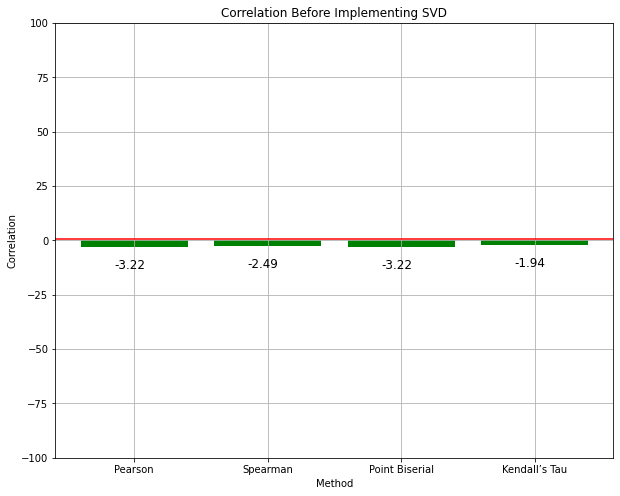

In [ ]:
fig = plt.figure(figsize=(10, 8))
method = ['Pearson', 'Spearman', 'Point Biserial', 'Kendall’s Tau']
result = np.around(np.array([
          calculate_correlation(train['Vector1'], train['Vector2'], train['Overall'], method=Correlation.PEARSON_CORRELATION) * 100,
          calculate_correlation(train['Vector1'], train['Vector2'], train['Overall'], method=Correlation.SPEARMAN_CORRELATION) * 100,
          calculate_correlation(train['Vector1'], train['Vector2'], train['Overall'], method=Correlation.POINT_BISERIAL_CORRELATION) * 100,
          calculate_correlation(train['Vector1'], train['Vector2'], train['Overall'], method=Correlation.KENDALL_TAU_CORRELATION) * 100,
]),2)
plt.title('Correlation Before Implementing SVD')
pl = plt.bar(method, result, color ='green')
plt.xlabel('Method')
plt.ylabel('Correlation')
plt.ylim(-100, 100)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.grid()
for bar in pl:
  plt.annotate(bar.get_height(), xy=(bar.get_x()+0.25, bar.get_height()-10), fontsize=12)

plt.show()

#### Metrics after transformation

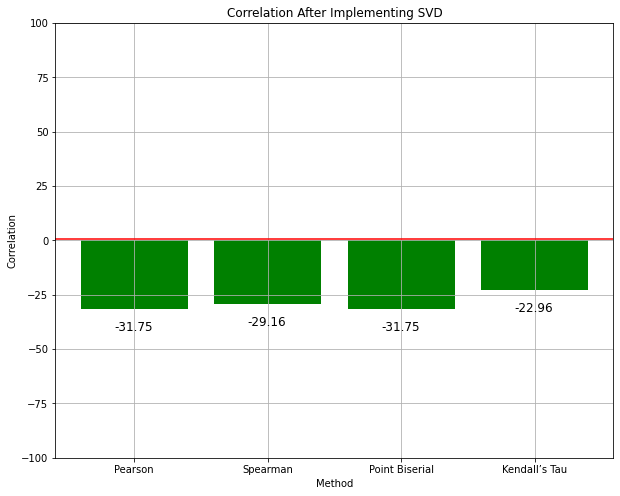

In [ ]:
fig = plt.figure(figsize=(10, 8))
method = ['Pearson', 'Spearman', 'Point Biserial', 'Kendall’s Tau']
result = np.around(np.array([
          calculate_correlation(transformed, test['Vector1'], test['Overall'], method=Correlation.PEARSON_CORRELATION) * 100,
          calculate_correlation(transformed, test['Vector1'], test['Overall'], method=Correlation.SPEARMAN_CORRELATION) * 100,
          calculate_correlation(transformed, test['Vector1'], test['Overall'], method=Correlation.POINT_BISERIAL_CORRELATION) * 100,
          calculate_correlation(transformed, test['Vector1'], test['Overall'], method=Correlation.KENDALL_TAU_CORRELATION) * 100,
]),2)
plt.title('Correlation After Implementing SVD')
pl = plt.bar(method, result, color ='green')
plt.xlabel('Method')
plt.ylabel('Correlation')
plt.ylim(-100, 100)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.grid()
for bar in pl:
  plt.annotate(bar.get_height(), xy=(bar.get_x()+0.25, bar.get_height()-10), fontsize=12)

plt.show()